# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-portfolio-allocation-9b417660c7cd
* Please report any issues to our Github: https://github.com/AI4Finance-Foundation/FinRL/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for portfolio alloacation. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A represents the weight of a stock in the porfolio: a ∈ (-1,1). Assume our stock pool includes N stocks, we can use a list [a<sub>1</sub>, a<sub>2</sub>, ... , a<sub>N</sub>] to determine the weight for each stock in the porfotlio, where a<sub>i</sub> ∈ (-1,1), a<sub>1</sub>+ a<sub>2</sub>+...+a<sub>N</sub>=1. For example, "The weight of AAPL in the portfolio is 10%." is [0.1 , ...].

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
# !pip install wrds
# !pip install swig
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [2]:
# !pip install pandas_market_calendars yfinance alpaca-trade-api stockstats stable-baselines3



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [5]:
TW_STOCK_TICKER = [
    '2330.TW',  # 台積電
    '2317.TW',  # 鴻海
    '2454.TW',  # 聯發科
    '2308.TW',  # 台達電
    '2881.TW',  # 富邦金
    '2882.TW',  # 國泰金
    '2301.TW',  # 光寶科
    '2412.TW',  # 中華電
    '1301.TW',  # 台塑
    '2002.TW',  # 中鋼
    '1303.TW',  # 南亞
    '1326.TW',  # 台化
    '2891.TW',  # 中信金
    '3008.TW',  # 大立光
    '3711.TW',  # 日月光投控
    '2886.TW',  # 兆豐金
    '2603.TW',  # 長榮
    '2609.TW',  # 陽明
    '2615.TW',  # 萬海
    '2382.TW',  # 廣達
    '2884.TW',  # 玉山金
    '2892.TW',  # 第一金
    '2880.TW',  # 華南金
    '2890.TW',  # 永豐金
    '3006.TW',  # 晶豪科
    '1101.TW',  # 台泥
    '1102.TW',  # 亞泥
    '1402.TW',  # 遠東新
    '1722.TW',  # 台肥
    '3045.TW',  # 台灣大
    '9910.TW',  # 豐興
    '9911.TW',  # 櫻花
    '0050.TW',  # 元大台灣50（ETF）
    '2357.TW',  # 華碩
    '2347.TW',  # 聯強
    '2883.TW',  # 開發金
    '2606.TW',  # 裕民
    '3481.TW',  # 群創
    '2408.TW',  # 南亞科
    '3673.TW',  # TPK-KY
    '2303.TW',  # 聯電
    '2356.TW',  # 英業達
    '2305.TW',  # 全友
    '2379.TW',  # 瑞昱
    '3231.TW',  # 緯創
    '2354.TW',  # 鴻準
    '2618.TW',  # 長榮航
    '2885.TW',  # 元大金
    '3005.TW',  # 神基
    '2377.TW',  # 微星
]


<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [6]:
# dp = YahooFinanceProcessor()
# df = dp.download_data(start_date='2020-01-01',
#                      end_date='2024-10-31',
#                      ticker_list=TW_STOCK_TICKER[:3],  # 使用你定義的台灣股票代碼
#                      time_interval='1D')
# df = df.dropna(subset=['close'])

folder_path = "/Users/gary/Documents/project/RL/code/converted_stock"  # 將這裡替換成你的資料夾路徑
all_files = os.listdir(folder_path)
csv_files = [f for f in all_files if f.endswith('.csv')]  # 只處理 CSV 檔案

df_list = []
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)
    df_list.append(df)

df_combined = pd.concat(df_list, ignore_index=True)  # 合併所有 DataFrame
print("所有 CSV 檔案已合併。")
print(df_combined.head())


所有 CSV 檔案已合併。
         date       open       high        low      close   volume      tic
0  2020-01-02  80.399082  80.399082  79.836291  80.077484  3326184  1301.TW
1  2020-01-03  80.077488  81.605072  79.836295  81.605072  5636265  1301.TW
2  2020-01-06  81.605077  82.007072  81.203082  82.007072  6514815  1301.TW
3  2020-01-07  81.605072  82.007067  81.203077  81.605072  6945442  1301.TW
4  2020-01-08  81.605065  81.605065  80.399078  80.399078  4643180  1301.TW


In [7]:
df.head()

,date,open,high,low,close,volume,tic
0,2020-01-02,19.913036,19.996008,19.830065,19.913036,6939981,2002.TW
1,2020-01-03,19.954523,19.996010,19.871554,19.996010,12353288,2002.TW
2,2020-01-06,19.913036,19.954521,19.747093,19.747093,7042674,2002.TW
3,2020-01-07,19.747095,19.830066,19.664125,19.664125,7693624,2002.TW
4,2020-01-08,19.664125,19.664125,19.498182,19.539667,9093876,2002.TW


In [8]:
df.shape

(1172, 7)

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)
df.rename(columns={'timestamp': 'date'}, inplace=True)


df = fe.preprocess_data(df)

Successfully added technical indicators


In [10]:
df.shape

(1172, 15)

In [11]:
df.head()

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2020-01-02,19.913036,19.996008,19.830065,19.913036,6939981,2002.TW,0.000000,20.071865,19.837181,100.000000,66.666667,100.000000,19.913036,19.913036
1,2020-01-03,19.954523,19.996010,19.871554,19.996010,12353288,2002.TW,0.001862,20.071865,19.837181,100.000000,66.666667,100.000000,19.954523,19.954523
2,2020-01-06,19.913036,19.954521,19.747093,19.747093,7042674,2002.TW,-0.005347,20.138864,19.631896,24.370030,-100.000000,99.996725,19.885380,19.885380
3,2020-01-07,19.747095,19.830066,19.664125,19.664125,7693624,2002.TW,-0.011490,20.133034,19.527098,19.329343,-105.554145,99.998087,19.830066,19.830066
4,2020-01-08,19.664125,19.664125,19.498182,19.539667,9093876,2002.TW,-0.019539,20.141185,19.402788,14.632632,-125.382646,99.998988,19.771986,19.771986


## Add covariance matrix as states

In [12]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values
  cov_list.append(covs)


df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)


In [13]:
df.shape

(920, 17)

In [14]:
df.head()

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2021-01-13,21.511254,21.723816,21.383717,21.723816,37195138,2002.TW,0.531992,22.277576,20.171018,65.160645,88.666503,61.415230,20.859400,19.554270,[[0.00017084856336006465]],tic 2002.TW date 2020...
1,2021-01-14,21.851357,21.893869,21.468745,21.511257,34214852,2002.TW,0.491553,22.298133,20.226985,62.850032,84.388618,63.464878,20.916083,19.621581,[[0.00017120559802933616]],tic 2002.TW date 2020...
2,2021-01-15,21.511256,21.596281,21.128646,21.171158,47036480,2002.TW,0.427137,22.291834,20.275796,59.365640,41.004001,46.794072,20.961429,19.683224,[[0.00017159397417009197]],tic 2002.TW date 2020...
3,2021-01-18,21.001108,21.001108,20.490959,20.618496,36711070,2002.TW,0.327715,22.303586,20.247039,54.304650,-38.390195,21.880701,20.985520,19.736365,[[0.00017429411546342267]],tic 2002.TW date 2020...
4,2021-01-19,20.703522,20.873571,20.618497,20.661009,22731817,2002.TW,0.249476,22.311999,20.183359,54.612557,-41.828724,21.880701,21.009610,19.787380,[[0.00017413196461476863]],tic 2002.TW date 2020...


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.


## Training data split: 2020-01-01 to 2024-10-31

In [15]:
train = data_split(df, '2020-01-01','2024-10-30')
# train = train.set_index('date')

#trade = data_split(df, '2020-01-01', config.END_DATE)

In [16]:
train.head()

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2021-01-13,21.511254,21.723816,21.383717,21.723816,37195138,2002.TW,0.531992,22.277576,20.171018,65.160645,88.666503,61.415230,20.859400,19.554270,[[0.00017084856336006465]],tic 2002.TW date 2020...
1,2021-01-14,21.851357,21.893869,21.468745,21.511257,34214852,2002.TW,0.491553,22.298133,20.226985,62.850032,84.388618,63.464878,20.916083,19.621581,[[0.00017120559802933616]],tic 2002.TW date 2020...
2,2021-01-15,21.511256,21.596281,21.128646,21.171158,47036480,2002.TW,0.427137,22.291834,20.275796,59.365640,41.004001,46.794072,20.961429,19.683224,[[0.00017159397417009197]],tic 2002.TW date 2020...
3,2021-01-18,21.001108,21.001108,20.490959,20.618496,36711070,2002.TW,0.327715,22.303586,20.247039,54.304650,-38.390195,21.880701,20.985520,19.736365,[[0.00017429411546342267]],tic 2002.TW date 2020...
4,2021-01-19,20.703522,20.873571,20.618497,20.661009,22731817,2002.TW,0.249476,22.311999,20.183359,54.612557,-41.828724,21.880701,21.009610,19.787380,[[0.00017413196461476863]],tic 2002.TW date 2020...


## Environment for Portfolio Allocation


In [17]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv

class StockPortfolioEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self,
                 df,
                 stock_dim,
                 hmax,
                 initial_amount,
                 transaction_cost_pct,
                 reward_scaling,
                 state_space,
                 action_space,
                 tech_indicator_list,
                 turbulence_threshold=None,
                 lookback=252,
                 day=0):

        self.day = day
        self.lookback = lookback
        self.df = df.reset_index(drop=True)
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.turbulence_threshold = turbulence_threshold

        self.action_space = spaces.Box(low=0, high=1, shape=(self.action_space,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.state_space + len(self.tech_indicator_list), self.state_space),
                                            dtype=np.float32)

        self.data = self.df[self.df.date == self.df.date.unique()[self.day]]
        self.covs = self.data['cov_list'].iloc[0]
        tech_array = [self.data[tech].values.tolist() for tech in self.tech_indicator_list]
        self.state = np.vstack([np.array(self.covs).reshape(1, -1), np.array(tech_array)])

        self.terminal = False
        self.portfolio_value = self.initial_amount
        self.asset_memory = [self.initial_amount]
        self.portfolio_return_memory = [0]
        self.actions_memory = [[1 / self.stock_dim] * self.stock_dim]
        self.date_memory = [self.data.date.values[0]]

    def step(self, actions):
        self.terminal = self.day >= len(self.df.date.unique()) - 1

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory, columns=['daily_return'])
            plt.plot(df.daily_return.cumsum(), 'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()

            plt.plot(self.portfolio_return_memory, 'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print(f"begin_total_asset: {self.asset_memory[0]}")
            print(f"end_total_asset: {self.portfolio_value}")

            if df['daily_return'].std() != 0:
                sharpe = (252 ** 0.5) * df['daily_return'].mean() / df['daily_return'].std()
                print("Sharpe: ", sharpe)
            print("=================================")
            return self.state, self.reward, self.terminal, {}

        weights = self.softmax_normalization(actions)
        self.actions_memory.append(weights)
        last_day_data = self.data

        self.day += 1
        self.data = self.df[self.df.date == self.df.date.unique()[self.day]]
        self.covs = self.data['cov_list'].iloc[0]
        tech_array = [self.data[tech].values.tolist() for tech in self.tech_indicator_list]
        self.state = np.vstack([np.array(self.covs).reshape(1, -1), np.array(tech_array)])

        portfolio_return = sum(((self.data.close.values / last_day_data.close.values) - 1) * weights)
        new_portfolio_value = self.portfolio_value * (1 + portfolio_return)
        self.portfolio_value = new_portfolio_value

        self.portfolio_return_memory.append(portfolio_return)
        self.date_memory.append(self.data.date.values[0])
        self.asset_memory.append(new_portfolio_value)

        self.reward = portfolio_return * self.reward_scaling
        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df[self.df.date == self.df.date.unique()[self.day]]
        self.covs = self.data['cov_list'].iloc[0]
        tech_array = [self.data[tech].values.tolist() for tech in self.tech_indicator_list]
        self.state = np.vstack([np.array(self.covs).reshape(1, -1), np.array(tech_array)])

        self.portfolio_value = self.initial_amount
        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory = [[1 / self.stock_dim] * self.stock_dim]
        self.date_memory = [self.data.date.values[0]]
        return self.state

    def render(self, mode='human'):
        return self.state

    def softmax_normalization(self, actions):
        numerator = np.exp(actions - np.max(actions))
        return numerator / np.sum(numerator)

    def save_asset_memory(self):
        df_account_value = pd.DataFrame({
            'date': self.date_memory,
            'daily_return': self.portfolio_return_memory,
            'account_value': self.asset_memory
        })
        return df_account_value

    def save_action_memory(self):
        df_date = pd.DataFrame(self.date_memory, columns=['date'])
        df_actions = pd.DataFrame(self.actions_memory)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [18]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 1


In [19]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [20]:
!pip install "shimmy>=2.0"


In [21]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [22]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [23]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [24]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=50000)

------------------------------------
| time/                 |          |
|    fps                | 1191     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.42    |
|    explained_variance | -660     |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 0.0357   |
|    reward             | 0.0      |
|    std                | 1        |
|    value_loss         | 0.0053   |
------------------------------------
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
-----------------------------------------
| time/                 |               |
|    fps                | 1202          |
|    iterations         | 200           |
|    time_elapsed       | 0             |
|    total_timesteps    | 1000          |
| train/                |               |
|    entropy_loss     

In [25]:
trained_a2c.save('/Users/gary/Documents/project/RL/code/code/trained_models/trained_a2c.zip')

### Model 2: **PPO**


In [26]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [27]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=80000)

begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
-----------------------------
| time/              |      |
|    fps             | 1949 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
| train/             |      |
|    reward          | 0.0  |
-----------------------------
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
-------------------------------------------
| time/                   |               |
|    fps                  | 1834          |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.0015232009  |
|    clip_

In [28]:
trained_ppo.save('/Users/gary/Documents/project/RL/code/code/trained_models/trained_ppo.zip')

### Model 3: **DDPG**


In [29]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [30]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000)

begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 293          |
|    time_elapsed    | 12           |
|    total_timesteps | 3676         |
| train/             |              |
|    actor_loss      | 0.113        |
|    critic_loss     | 0.0222       |
|    learning_rate   | 0.001        |
|    n_updates       | 3575         |
|    reward          | -6.59339e-07 |
-------------------------------------
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 10

In [31]:
trained_ddpg.save('/Users/gary/Documents/project/RL/code/code/trained_models/trained_ddpg.zip')

### Model 4: **SAC**


In [32]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [33]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=50000)

begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 218          |
|    time_elapsed    | 16           |
|    total_timesteps | 3676         |
| train/             |              |
|    actor_loss      | 6.12         |
|    critic_loss     | 0.0467       |
|    ent_coef        | 0.0342       |
|    ent_coef_loss   | -5.32        |
|    learning_rate   | 0.0003       |
|    n_updates       | 3575         |
|    reward          | -6.59339e-07 |
-------------------------------------
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806

In [34]:
trained_sac.save('/Users/gary/Documents/project/RL/code/code/trained_models/trained_sac.zip')

### Model 5: **TD3**


In [35]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [36]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=30000)

begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 297          |
|    time_elapsed    | 12           |
|    total_timesteps | 3676         |
| train/             |              |
|    actor_loss      | 4.01         |
|    critic_loss     | 0.528        |
|    learning_rate   | 0.001        |
|    n_updates       | 3575         |
|    reward          | -6.59339e-07 |
-------------------------------------
begin_total_asset: 1000000
end_total_asset: 1040332.8985482806
Sharpe:  0.17497534205410323
begin_total_asset: 1000000
end_total_asset: 10

In [37]:
trained_td3.save('/Users/gary/Documents/project/RL/code/code/trained_models/trained_td3.zip')

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

In [38]:
trade = data_split(df,'2024-01-01', '2024-10-31')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [39]:
trade.shape

(199, 17)

In [40]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset: 1000000
end_total_asset: 846125.7181483138
Sharpe:  -1.029383047568629
hit end!


/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [41]:
df_daily_return.head()

,date,daily_return,account_value
0,2024-01-02,0.000000,1000000.000000
1,2024-01-03,-0.011111,988888.919174
2,2024-01-04,0.000000,988888.919174
3,2024-01-05,0.000000,988888.919174
4,2024-01-08,-0.007491,981481.460229


In [42]:
df_daily_return.to_csv('df_daily_return.csv')

In [43]:
df_actions.head()

,2002.TW
date,
2024-01-02,1.0
2024-01-03,1.0
2024-01-04,1.0
2024-01-05,1.0
2024-01-08,1.0


In [44]:
df_actions.to_csv('df_actions.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [45]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats
perf_stats_all = perf_func( returns=DRL_strat,
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

In [46]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return         -0.190702
Cumulative returns    -0.153874
Annual volatility      0.188373
Sharpe ratio          -1.029383
Calmar ratio          -0.793378
Stability              0.677011
Max drawdown          -0.240367
Omega ratio            0.833391
Sortino ratio         -1.476197
Skew                   0.603180
Kurtosis               5.114223
Tail ratio             1.042635
Daily value at risk   -0.024502
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [47]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (209, 8)
Annual return          0.146166
Cumulative returns     0.119793
Annual volatility      0.107364
Sharpe ratio           1.330603
Calmar ratio           2.413719
Stability              0.758154
Max drawdown          -0.060556
Omega ratio            1.245858
Sortino ratio          1.909857
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.959812
Daily value at risk   -0.012960
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (209, 8)



/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-23.123%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2024-01-02
End date,2024-10-29
Total months,9
,Backtest
Annual return,-23.123%
Cumulative returns,-18.07%
Annual volatility,18.915%
Sharpe ratio,-1.30
Calmar ratio,-0.86
Stability,0.75
Max drawdown,-26.771%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.77,2024-01-02,2024-09-11,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,-0.08%,-4.57%,6.21%


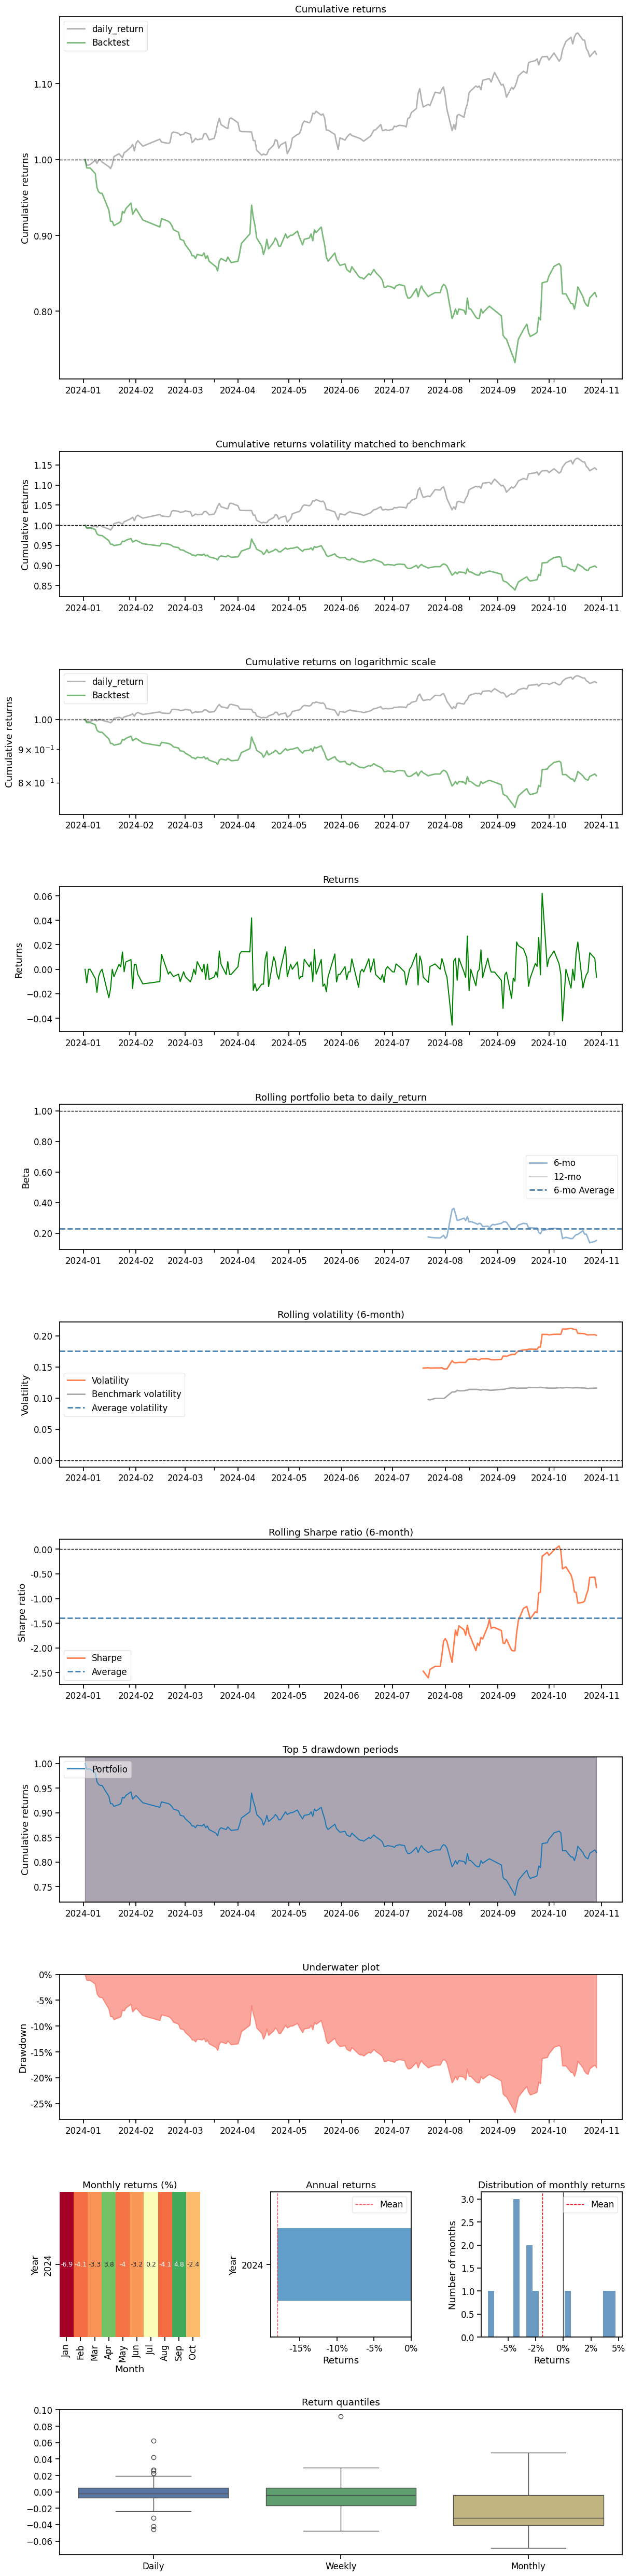

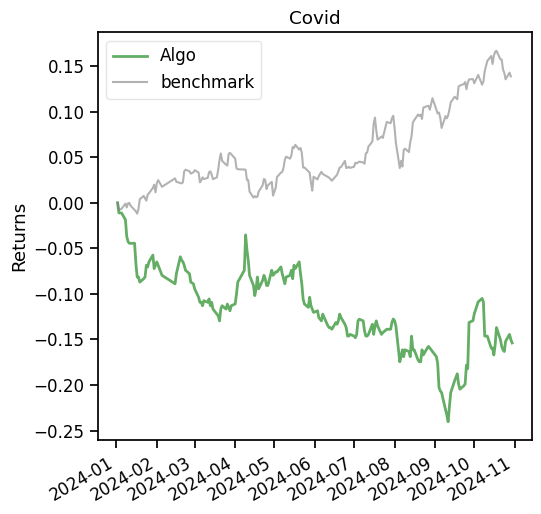

In [48]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2024-10-30'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")
# 只保留策略有資料的日期
baseline_returns = baseline_returns.loc[baseline_returns.index.isin(DRL_strat.index)]

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

## Min-Variance Portfolio Allocation

In [49]:
%pip install PyPortfolioOpt

Note: you may need to restart the kernel to use updated packages.


In [50]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [51]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [52]:
df.head()

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2021-01-13,21.511254,21.723816,21.383717,21.723816,37195138,2002.TW,0.531992,22.277576,20.171018,65.160645,88.666503,61.415230,20.859400,19.554270,[[0.00017084856336006465]],tic 2002.TW date 2020...
1,2021-01-14,21.851357,21.893869,21.468745,21.511257,34214852,2002.TW,0.491553,22.298133,20.226985,62.850032,84.388618,63.464878,20.916083,19.621581,[[0.00017120559802933616]],tic 2002.TW date 2020...
2,2021-01-15,21.511256,21.596281,21.128646,21.171158,47036480,2002.TW,0.427137,22.291834,20.275796,59.365640,41.004001,46.794072,20.961429,19.683224,[[0.00017159397417009197]],tic 2002.TW date 2020...
3,2021-01-18,21.001108,21.001108,20.490959,20.618496,36711070,2002.TW,0.327715,22.303586,20.247039,54.304650,-38.390195,21.880701,20.985520,19.736365,[[0.00017429411546342267]],tic 2002.TW date 2020...
4,2021-01-19,20.703522,20.873571,20.618497,20.661009,22731817,2002.TW,0.249476,22.311999,20.183359,54.612557,-41.828724,21.880701,21.009610,19.787380,[[0.00017413196461476863]],tic 2002.TW date 2020...


In [53]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma)

    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()

    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)

portfolio=portfolio.T
portfolio.columns = ['account_value']

In [54]:
portfolio.head()

,account_value
2024-01-02,1000000
2024-01-03,988888.919174
2024-01-04,988888.919174
2024-01-05,988888.919174
2024-01-08,981481.460229


In [55]:
a2c_cumpod =(df_daily_return.daily_return+1).cumprod()-1

In [56]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1

/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_49345/3389022641.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1


In [57]:
dji_cumpod =(baseline_returns+1).cumprod()-1

## Plotly: DRL, Min-Variance, DJIA

In [58]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [59]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [60]:
time_ind = pd.Series(df_daily_return.date)

In [61]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
#trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [62]:
import plotly.graph_objects as go

# 初始化顯示設定
import plotly.io as pio
try:
    import nbformat
    from packaging.version import Version
    if Version(nbformat.__version__) >= Version("4.2.0"):
        pio.renderers.default = "notebook_connected"
    else:
        pio.renderers.default = "browser"
except ImportError:
    pio.renderers.default = "browser"
fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)



fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2

    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date',
       'tick0': time_ind[0],
        'tickmode': 'linear',
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()